## Comparing masks found by OES (at initialization) and IMP (at convergence) in denoising

In [28]:
from __future__ import print_function
import matplotlib.pyplot as plt
import warnings
from utils.denoising_utils import *
from models import *
from utils.quant import *
from utils.imp import *
import torch
import torch.optim
from skimage.metrics import peak_signal_noise_ratio as compare_psnr
import pickle as cPickle
#Suppress warnings
warnings.filterwarnings("ignore")

# Enable CUDA
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True
dtype = torch.cuda.FloatTensor
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load the images 

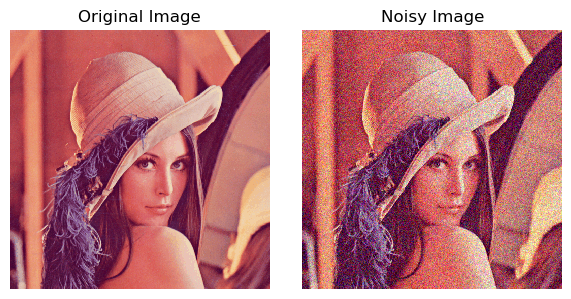

The PSNR of the noisy image is 20.204697782335096


In [29]:
train_folder = 'images'
image_name='lena'
sigma=0.1
img_np, img_noisy_np, noisy_psnr = load_image(train_folder, image_name, sigma)
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(6, 3))

# Plot original image
axes[0].imshow(img_np.transpose(1, 2, 0))
axes[0].set_title('Original Image')
axes[0].axis('off')  # Optional: to turn off the axis

# Plot noisy image
axes[1].imshow(img_noisy_np.transpose(1, 2, 0))
axes[1].set_title('Noisy Image')
axes[1].axis('off')  # Optional: to turn off the axis

# Display the plots
plt.tight_layout()
plt.show()

print(f"The PSNR of the noisy image is {noisy_psnr}")

### Load the OES mask and mask the model

In [32]:
input_depth = 32
output_depth = 3
num_layers = 6
max_steps=20000
show_every=1000
transferimage_name='pepper'

mse = torch.nn.MSELoss().type(dtype)
net_input = get_noise(input_depth, "noise", img_np.shape[1:]).type(dtype)

masked_model = skip(
    input_depth, output_depth,
    num_channels_down=[16, 32, 64, 128, 128, 128][:num_layers],
    num_channels_up=[16, 32, 64, 128, 128, 128][:num_layers],
    num_channels_skip=[0] * num_layers,
    upsample_mode='nearest',
    downsample_mode='avg',
    need1x1_up=False,
    filter_size_down=5,
    filter_size_up=3,
    filter_skip_size=1,
    need_sigmoid=True,
    need_bias=True,
    pad='reflection',
    act_fun='LeakyReLU'
).type(dtype)

outdir = f'sparse_models/{transferimage_name}'
with open(f'{outdir}/net_input_list_{transferimage_name}.pkl', 'rb') as f:
    net_input_list = cPickle.load(f)
with open(f'{outdir}/mask_{transferimage_name}.pkl', 'rb') as f:
    mask = cPickle.load(f)   
masked_model = mask_network(mask, masked_model)


### Train the OES masked network

In [33]:
psnr_pai, out_pai = train_sparse(masked_model, net_input_list, mask, img_np, img_noisy_np, max_step=max_steps, show_every=show_every, device='cuda:0')

1.1.1.weight         | nonzeros =     868 /   12800             (  6.78%) | total_pruned =   11932 | shape = torch.Size([16, 32, 5, 5])
1.1.1.bias           | nonzeros =       0 /      16             (  0.00%) | total_pruned =      16 | shape = torch.Size([16])
1.2.weight           | nonzeros =       6 /      16             ( 37.50%) | total_pruned =      10 | shape = torch.Size([16])
1.2.bias             | nonzeros =       0 /      16             (  0.00%) | total_pruned =      16 | shape = torch.Size([16])
1.4.1.weight         | nonzeros =     134 /    6400             (  2.09%) | total_pruned =    6266 | shape = torch.Size([16, 16, 5, 5])
1.4.1.bias           | nonzeros =       0 /      16             (  0.00%) | total_pruned =      16 | shape = torch.Size([16])
1.5.weight           | nonzeros =       6 /      16             ( 37.50%) | total_pruned =      10 | shape = torch.Size([16])
1.5.bias             | nonzeros =       0 /      16             (  0.00%) | total_pruned =      16

epoch:  1000 loss:  0.01051071286201477 PSNR:  28.49866141205277 PSNR_noisy:  19.783678416527376
epoch:  2000 loss:  0.00995855126529932 PSNR:  29.057779544335794 PSNR_noisy:  20.01803862429327
epoch:  3000 loss:  0.00958901084959507 PSNR:  28.952004796985552 PSNR_noisy:  20.182262107161627
epoch:  4000 loss:  0.009328465908765793 PSNR:  28.68837781880494 PSNR_noisy:  20.30189780112595
epoch:  5000 loss:  0.009208477102220058 PSNR:  28.36735071359589 PSNR_noisy:  20.358122198600373
epoch:  6000 loss:  0.009144239127635956 PSNR:  28.15156598601298 PSNR_noisy:  20.388524386226486
epoch:  7000 loss:  0.0090278759598732 PSNR:  28.040839395496732 PSNR_noisy:  20.444144147066837
epoch:  8000 loss:  0.008963494561612606 PSNR:  27.868884394163466 PSNR_noisy:  20.47522652358992
epoch:  9000 loss:  0.008863035589456558 PSNR:  27.886132753141464 PSNR_noisy:  20.52417529268276
epoch:  10000 loss:  0.008878448978066444 PSNR:  27.662956199491234 PSNR_noisy:  20.51662938529266
epoch:  11000 loss:  0.

### Load the IMP found mask

In [36]:
outdir = f'sparse_models_imp/{transferimage_name}'
print(f"Output directory: {outdir}")
model_path = f'{outdir}/model_final.pth'
net_input_list_imp = torch.load(f'{outdir}/net_input_final.pth')
mask_imp = torch.load(f'{outdir}/mask_final.pth')

masked_model_imp = skip(
    input_depth, output_depth,
    num_channels_down=[16, 32, 64, 128, 128, 128][:num_layers],
    num_channels_up=[16, 32, 64, 128, 128, 128][:num_layers],
    num_channels_skip=[0] * num_layers,
    upsample_mode='nearest',
    downsample_mode='avg',
    need1x1_up=False,
    filter_size_down=5,
    filter_size_up=3,
    filter_skip_size=1,
    need_sigmoid=True,
    need_bias=True,
    pad='reflection',
    act_fun='LeakyReLU'
).type(dtype)

masked_model_imp = mask_network(mask_imp, masked_model_imp)

Output directory: sparse_models_imp/pepper


### Train the IMP masked network

In [37]:
psnr_imp, out_imp = train_sparse(masked_model_imp, net_input_list_imp, mask_imp, img_np, img_noisy_np, max_step=max_steps, show_every=show_every, device='cuda:0')

1.1.1.weight         | nonzeros =    1313 /   12800             ( 10.26%) | total_pruned =   11487 | shape = torch.Size([16, 32, 5, 5])
1.1.1.bias           | nonzeros =       0 /      16             (  0.00%) | total_pruned =      16 | shape = torch.Size([16])
1.2.weight           | nonzeros =      16 /      16             (100.00%) | total_pruned =       0 | shape = torch.Size([16])
1.2.bias             | nonzeros =       0 /      16             (  0.00%) | total_pruned =      16 | shape = torch.Size([16])
1.4.1.weight         | nonzeros =     570 /    6400             (  8.91%) | total_pruned =    5830 | shape = torch.Size([16, 16, 5, 5])
1.4.1.bias           | nonzeros =       0 /      16             (  0.00%) | total_pruned =      16 | shape = torch.Size([16])
1.5.weight           | nonzeros =      16 /      16             (100.00%) | total_pruned =       0 | shape = torch.Size([16])
1.5.bias             | nonzeros =       0 /      16             (  0.00%) | total_pruned =      16

epoch:  1000 loss:  0.010137665085494518 PSNR:  28.845370273090765 PSNR_noisy:  19.94062074979172
epoch:  2000 loss:  0.009334742091596127 PSNR:  28.432654100825864 PSNR_noisy:  20.298976768942172
epoch:  3000 loss:  0.009081716649234295 PSNR:  27.588847375509435 PSNR_noisy:  20.4183205000847
epoch:  4000 loss:  0.008760345168411732 PSNR:  27.244146457794663 PSNR_noisy:  20.57478790922421
epoch:  5000 loss:  0.008560579270124435 PSNR:  27.138700978230368 PSNR_noisy:  20.674968408750082
epoch:  6000 loss:  0.00850613508373499 PSNR:  26.789764227818786 PSNR_noisy:  20.702677481301208
epoch:  7000 loss:  0.008369313552975655 PSNR:  26.897563365823164 PSNR_noisy:  20.77310216485051
epoch:  8000 loss:  0.008358394727110863 PSNR:  26.702689632964855 PSNR_noisy:  20.778771477415397
epoch:  9000 loss:  0.008261408656835556 PSNR:  26.737175614570926 PSNR_noisy:  20.82945861430977
epoch:  10000 loss:  0.008232681080698967 PSNR:  26.532557546672297 PSNR_noisy:  20.844587308587144
epoch:  11000 lo

### Plot the training curves

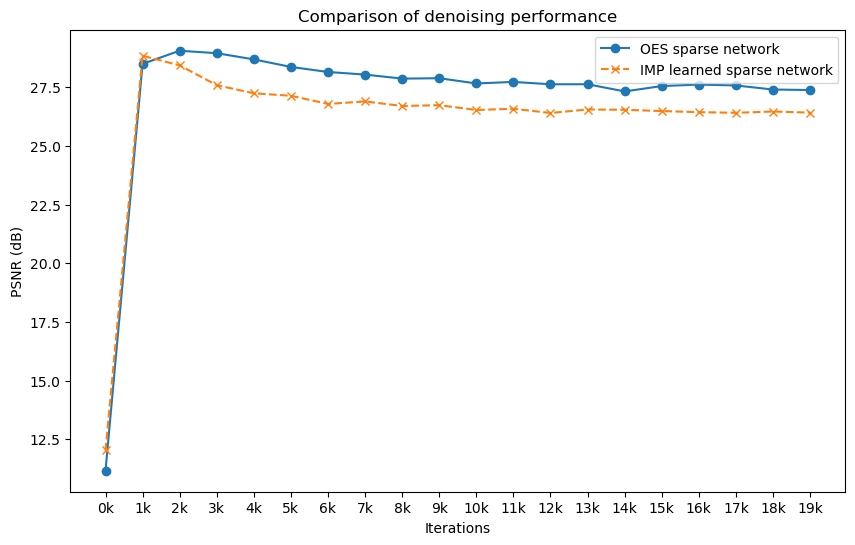

In [38]:
plt.figure(figsize=(10, 6))
plt.plot(psnr_pai, label='OES sparse network', marker='o', linestyle='-')
plt.plot(psnr_imp, label='IMP learned sparse network', marker='x', linestyle='--')


# Label the axes
plt.xlabel('Iterations')
plt.ylabel('PSNR (dB)')

# Add a title
plt.title('Comparison of denoising performance')


num_iterations = len(psnr_pai)  
xticks = range(0, num_iterations * 1000, 1000)
xtick_labels = [f'{i // 1000}k' for i in xticks]  
plt.xticks(ticks=range(0, num_iterations), labels=xtick_labels)

# Add a legend
plt.legend()

# Display the plot
plt.show()